In [3]:
import numpy as np
import pandas as pd
import os
import gymnasium as gym
from gymnasium import spaces
from scipy.special import softmax
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from typing import Dict, List, Tuple, Optional
from sklearn.preprocessing import MinMaxScaler

class PortfolioEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, stock_data_list: List[pd.DataFrame], episode_length: int = 12, temperature: float = 0.3, window_size: int = 252):
        super(PortfolioEnv, self).__init__()
        
        self.stocks = {f'stock_{i}': df for i, df in enumerate(stock_data_list)}
        self.n_stocks = len(self.stocks)
        self.episode_length = episode_length
        self.temperature = temperature
        self.window_size = window_size  # Window size for feature scaling (252 days = 1 year)
        
        # Use raw features instead of pre-scaled ones
        self.features = [
            'Close', 'MA5', 'MA20', 'MA50', 'MA200',
            'RSI', 'BB_width', 'ATR', 'Return_1W',
            'Return_1M', 'Return_3M', 'CurrentDrawdown',
            'MaxDrawdown_252d', 'Sharpe_20d', 'Sharpe_60d'
        ]
        
        obs_dim = len(self.features) * self.n_stocks
        self.observation_space = spaces.Box(
            low=-1, high=1,
            shape=(obs_dim,), 
            dtype=np.float32
        )
  
        self.action_space = spaces.Box(
            low=-1, high=1,
            shape=(self.n_stocks,),
            dtype=np.float32
        )
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        data_length = len(next(iter(self.stocks.values())))
        max_start_idx = data_length - self.episode_length * 30 - 20
        
        # No minimum start index, as data is assumed to be clean
        self.current_step = np.random.randint(0, max_start_idx)
        self.current_month = 0
        
        self.monthly_returns = []
        self.portfolio_value = 100.0
        self.previous_allocation = np.zeros(self.n_stocks)
        
        observation = self._get_observation()
        info = {}
        
        return observation, info
    
    
    def _get_observation(self):
        observation = []
        for stock_name, stock_data in self.stocks.items():
            # Get window for scaling (including current step)
            window_start = max(0, self.current_step - self.window_size + 1)  # +1 to make room for current step
            window_end = self.current_step + 1  # +1 because slice is exclusive of end index
            window_data = stock_data.iloc[window_start:window_end]
            
            # Scale all features for the entire window
            scaled_features = []
            for feature in self.features:
                scaler = MinMaxScaler(feature_range=(-1, 1))
                feature_values = window_data[feature].values.reshape(-1, 1)
                scaled_window = scaler.fit_transform(feature_values)
                
                # Get the scaled value for the current step (last value in the window)
                scaled_val = scaled_window[-1][0]  # Last row, first column
                scaled_features.append(scaled_val)
            observation.extend(scaled_features)
        return np.array(observation, dtype=np.float32)
    
    # Then update the _convert_to_allocation method:
    def _convert_to_allocation(self, action_weights):
        """
        Improved allocation conversion that handles inputs in the [-1, 1] range
        and converts them to portfolio allocations with constraints.
        """
        # No need to rescale the action_weights from [-1, 1]
        # Softmax works fine with negative values
        
        # Apply softmax with temperature scaling
        raw_allocation = softmax(np.array(action_weights) / self.temperature)
        
        # Calculate initial percent allocations
        percentages = raw_allocation * 100
        
        # Apply discretization constraint (0%, 10%, 20%, 30%)
        # First, find the nearest valid allocation (multiples of 10%)
        allocations = np.round(percentages / 10) * 10
        allocations = np.clip(allocations, 0, 30)
        
        # Determine adjustment needed to sum to 100%
        total_allocation = np.sum(allocations)
        adjustment_needed = 100 - total_allocation
        
        if adjustment_needed != 0:
            # Calculate how close each stock was to the next discretization level
            distance_to_next = np.zeros_like(allocations)
            
            for i in range(len(allocations)):
                if adjustment_needed > 0 and allocations[i] < 30:
                    # If we need to add: how close to rounding up?
                    distance_to_next[i] = 10 - (percentages[i] % 10)
                elif adjustment_needed < 0 and allocations[i] > 0:
                    # If we need to subtract: how close to rounding down?
                    distance_to_next[i] = percentages[i] % 10
                else:
                    # Can't adjust this stock
                    distance_to_next[i] = float('inf')
            
            # Prioritize adjustments for stocks closest to the next level
            num_adjustments = int(abs(adjustment_needed) // 10)
            
            if num_adjustments > 0:
                adjustment_indices = np.argsort(distance_to_next)[:num_adjustments]
                
                for idx in adjustment_indices:
                    if adjustment_needed > 0 and allocations[idx] < 30:
                        allocations[idx] += 10
                        adjustment_needed -= 10
                    elif adjustment_needed < 0 and allocations[idx] > 0:
                        allocations[idx] -= 10
                        adjustment_needed += 10
        
        return allocations
    
    
    def step(self, action):
        allocation = self._convert_to_allocation(action)
        
        self.previous_allocation = allocation.copy()
        
        portfolio_return, stock_returns = self._calculate_monthly_performance(allocation)
        
        self.portfolio_value *= (1 + portfolio_return)
        
        # Get raw metrics (not scaled) for reward calculation
        sharpe = self._calculate_portfolio_metric('Sharpe_20d', allocation)
        max_drawdown = self._calculate_portfolio_metric('MaxDrawdown_252d', allocation)
        
        reward = self._calculate_reward(portfolio_return, sharpe, max_drawdown)
        
        self.monthly_returns.append(portfolio_return)
        
        info = {
            'portfolio_return': portfolio_return,
            'portfolio_value': self.portfolio_value,
            'sharpe': sharpe,
            'max_drawdown': max_drawdown,
            'allocation': allocation.copy(),
            'stock_returns': stock_returns
        }
        
        self.current_step += 30
        self.current_month += 1
        
        terminated = (self.current_month >= self.episode_length)
        truncated = False
        
        observation = self._get_observation()
        
        return observation, reward, terminated, truncated, info
    
    def _calculate_monthly_performance(self, allocation):
        current_prices = np.array([
            self.stocks[f'stock_{i}'].iloc[self.current_step]['Close'] 
            for i in range(self.n_stocks)
        ])
        
        next_step = min(self.current_step + 30, len(next(iter(self.stocks.values()))) - 1)
        next_prices = np.array([
            self.stocks[f'stock_{i}'].iloc[next_step]['Close'] 
            for i in range(self.n_stocks)
        ])
        
        stock_returns = (next_prices - current_prices) / current_prices
        
        portfolio_return = np.sum((allocation / 100) * stock_returns)
        
        return portfolio_return, stock_returns
    
    def _calculate_portfolio_metric(self, metric_name, allocation):
        if not all(metric_name in stock_df.columns for stock_df in self.stocks.values()):
            return 0.0
        
        metric_values = np.array([
            self.stocks[f'stock_{i}'].iloc[self.current_step][metric_name] 
            for i in range(self.n_stocks)
        ])
        return np.sum((allocation / 100) * metric_values)
    
    def _calculate_reward(self, portfolio_return, sharpe, max_drawdown):
        """
        Calculate reward with more balanced risk-return consideration.
        Uses dynamic benchmarking rather than fixed thresholds.
        """
        # Get the average return across all stocks as a benchmark for the current month
        # The Return_1M metric is the return over the past month, not the future month
        benchmark_returns = np.mean([
            self.stocks[f'stock_{i}'].iloc[self.current_step].get('Return_1M', 0)
            for i in range(self.n_stocks)
        ])
        
        # Calculate excess return over benchmark
        excess_return = portfolio_return - max(0, benchmark_returns * 0.01)  # Scaled benchmark
        
        # Base reward from excess return (higher weight for outperformance)
        base_reward = excess_return * 100
        
        # Risk-adjusted components
        sharpe_component = sharpe * 1.0  # Increased weight on Sharpe
        drawdown_component = max_drawdown * -1.5  # Slightly reduced drawdown penalty
        
        # Apply higher penalty for large drawdowns but lower for small ones
        if max_drawdown < -0.1:  # Only penalize significant drawdowns
            drawdown_component *= 1.5
        
        # Combine components
        reward = base_reward + sharpe_component + drawdown_component
        
        return reward
    
    def render(self, mode='human'):
        print(f"Month {self.current_month}")
        print(f"Allocation: {self.previous_allocation}")
        if self.monthly_returns:
            print(f"Last month return: {self.monthly_returns[-1]:.4f}")
            print(f"Portfolio value: {self.portfolio_value:.2f}")
    
    def close(self):
        pass


def train_and_evaluate(stock_data_list, save_dir='./models', total_timesteps=100_000, eval_episodes=10, temperature=0.3):
    print("Creating environment...")
    env = PortfolioEnv(stock_data_list)
    
    check_env(env)
    
    print("Initializing PPO agent...")
    model = PPO(
        "MlpPolicy", 
        env,
        verbose=1,
        learning_rate=3e-4,
        gamma=0.99,
        n_steps=2048,
        ent_coef=0.01,
        vf_coef=0.5,
        max_grad_norm=0.5,
        tensorboard_log="./portfolio_env_logs",
        
        # policy_kwargs={'net_arch': [256, 128, dict(vf=[64], pi=[64])]}
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=1000,
        save_path=save_dir,
        name_prefix="ppo_portfolio",
        save_replay_buffer=False,
        save_vecnormalize=False,
    )
    
    print(f"Training for {total_timesteps} timesteps...")
    model.learn(
        total_timesteps=total_timesteps,
        callback=checkpoint_callback,
        progress_bar=True
    )
    
    final_model_path = os.path.join(save_dir, "ppo_portfolio_final")
    model.save(final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    print(f"Evaluating agent over {eval_episodes} episodes...")
    eval_env = PortfolioEnv(stock_data_list, temperature=temperature)
    eval_env = Monitor(eval_env)
    
    
    mean_reward, std_reward = evaluate_policy(
        model, 
        eval_env, 
        n_eval_episodes=eval_episodes,
        deterministic=True
    )
    
    print(f"Mean reward: {mean_reward:.4f} ± {std_reward:.4f}")
    
    results = detailed_evaluation(model, eval_env, n_episodes=eval_episodes)
    
    print("\nPerformance Summary:")
    print(f"Average Monthly Return: {results['mean_return']:.4f}")
    print(f"Average Sharpe Ratio: {results['mean_sharpe']:.4f}")
    print(f"Average Max Drawdown: {results['mean_drawdown']:.4f}")
    print(f"Final Average Portfolio Value: ${results['mean_final_value']:.2f}")
    
    return model, results


def detailed_evaluation(model, env, n_episodes=10):
    all_allocations = []
    all_returns = []
    all_sharpes = []
    all_drawdowns = []
    monthly_allocations = []
    final_values = []
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        episode_allocations = []
        episode_returns = []
        episode_sharpes = []
        episode_drawdowns = []
        done = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            
            obs, reward, terminated, truncated, info = env.step(action)
            
            done = terminated or truncated
            
            episode_allocations.append(info['allocation'])
            episode_returns.append(info['portfolio_return'])
            episode_sharpes.append(info['sharpe'])
            episode_drawdowns.append(info['max_drawdown'])
            
            if done:
                final_values.append(info['portfolio_value'])
        
        all_allocations.append(episode_allocations)
        monthly_allocations.extend(episode_allocations)
        all_returns.append(np.mean(episode_returns))
        all_sharpes.append(np.mean(episode_sharpes))
        all_drawdowns.append(np.mean(episode_drawdowns))
        
        print(f"Episode {episode+1}: Return = {np.mean(episode_returns):.4f}, Final Value = ${final_values[-1]:.2f}")
    
    avg_allocation = np.mean(monthly_allocations, axis=0)
    
    create_visualizations(
        avg_allocation, 
        all_returns, 
        all_sharpes, 
        all_drawdowns,
        final_values
    )
    
    return {
        'mean_return': np.mean(all_returns),
        'mean_sharpe': np.mean(all_sharpes),
        'mean_drawdown': np.mean(all_drawdowns),
        'mean_final_value': np.mean(final_values),
        'avg_allocation': avg_allocation
    }


def create_visualizations(avg_allocation, returns, sharpes, drawdowns, final_values):
    os.makedirs('results', exist_ok=True)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(avg_allocation)), avg_allocation)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%',
                 ha='center', va='bottom', rotation=0)
    
    plt.xlabel('Stock')
    plt.ylabel('Average Allocation (%)')
    plt.title('Average Portfolio Allocation')
    plt.xticks(range(len(avg_allocation)), [f'Stock {i}' for i in range(len(avg_allocation))])
    plt.ylim(0, max(avg_allocation) * 1.2)
    plt.savefig('results/portfolio_allocation.png')
    
    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=10, alpha=0.7)
    plt.axvline(np.mean(returns), color='r', linestyle='dashed', linewidth=2)
    plt.text(np.mean(returns)*1.1, plt.ylim()[1]*0.9, f'Mean: {np.mean(returns):.4f}')
    plt.xlabel('Average Monthly Return')
    plt.ylabel('Frequency')
    plt.title('Distribution of Average Monthly Returns')
    plt.savefig('results/returns_distribution.png')
    
    plt.figure(figsize=(10, 6))
    plt.hist(final_values, bins=10, alpha=0.7)
    plt.axvline(np.mean(final_values), color='r', linestyle='dashed', linewidth=2)
    plt.text(np.mean(final_values)*1.02, plt.ylim()[1]*0.9, f'Mean: ${np.mean(final_values):.2f}')
    plt.xlabel('Final Portfolio Value ($)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Final Portfolio Values (12-month episodes)')
    plt.savefig('results/portfolio_values.png')
    
    plt.figure(figsize=(12, 6))
    metrics = ['Return (%)', 'Sharpe', 'Drawdown (%)']
    values = [np.mean(returns)*100, np.mean(sharpes), np.mean(drawdowns)*100]
    colors = ['green', 'blue', 'red']
    
    bars = plt.bar(metrics, values, color=colors)
    plt.title('Average Performance Metrics')
    
    for bar in bars:
        height = bar.get_height()
        sign = "+" if height > 0 else ""
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 if height > 0 else height - 0.6,
                 f'{sign}{height:.2f}',
                 ha='center', va='bottom' if height > 0 else 'top')
    
    plt.savefig('results/performance_metrics.png')
    
    print("Visualizations saved to 'results' directory")

Loaded BIT with 2321 data points
Loaded CAQD with 2321 data points
Loaded CDUV with 2321 data points
Loaded CDZ with 2321 data points
Loaded CMA with 2321 data points
Creating environment...
Initializing PPO agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training for 100000 timesteps...
Logging to ./portfolio_env_logs/PPO_2


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 153      |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 2048     |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12           |
|    ep_rew_mean          | 36.5         |
| time/                   |              |
|    fps                  | 148          |
|    iterations           | 2            |
|    time_elapsed         | 27           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0124129485 |
|    clip_fraction        | 0.0899       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.09        |
|    explained_variance   | -0.00252     |
|    learning_rate        | 0.0003       |
|    loss                 | 85.8         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0184      |
|    std                  | 0.998        |
|    value_loss           | 214          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 38.2        |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 3           |
|    time_elapsed         | 41          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.016657477 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.08       |
|    explained_variance   | -0.00914    |
|    learning_rate        | 0.0003      |
|    loss                 | 64.4        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0199     |
|    std                  | 0.996       |
|    value_loss           | 165         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 35.2        |
| time/                   |             |
|    fps                  | 146         |
|    iterations           | 4           |
|    time_elapsed         | 56          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009798847 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.07       |
|    explained_variance   | 0.00489     |
|    learning_rate        | 0.0003      |
|    loss                 | 76.1        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0208     |
|    std                  | 0.995       |
|    value_loss           | 171         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 33.5        |
| time/                   |             |
|    fps                  | 144         |
|    iterations           | 5           |
|    time_elapsed         | 70          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.011789575 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.09       |
|    explained_variance   | 0.0938      |
|    learning_rate        | 0.0003      |
|    loss                 | 75.4        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0243     |
|    std                  | 1           |
|    value_loss           | 133         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 37.1        |
| time/                   |             |
|    fps                  | 146         |
|    iterations           | 6           |
|    time_elapsed         | 84          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.010850298 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.08       |
|    explained_variance   | 0.166       |
|    learning_rate        | 0.0003      |
|    loss                 | 69.6        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0217     |
|    std                  | 0.993       |
|    value_loss           | 125         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 36.8        |
| time/                   |             |
|    fps                  | 146         |
|    iterations           | 7           |
|    time_elapsed         | 97          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.009930238 |
|    clip_fraction        | 0.0992      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.05       |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.5        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0205     |
|    std                  | 0.989       |
|    value_loss           | 134         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 38.9        |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 8           |
|    time_elapsed         | 110         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009617283 |
|    clip_fraction        | 0.0934      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.04       |
|    explained_variance   | 0.253       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.8        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0199     |
|    std                  | 0.987       |
|    value_loss           | 129         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 39.3        |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 9           |
|    time_elapsed         | 124         |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.011548338 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.05       |
|    explained_variance   | 0.266       |
|    learning_rate        | 0.0003      |
|    loss                 | 54.7        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0256     |
|    std                  | 0.993       |
|    value_loss           | 127         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 40.9        |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 10          |
|    time_elapsed         | 137         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.009463502 |
|    clip_fraction        | 0.0881      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.05       |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.0003      |
|    loss                 | 52.1        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0217     |
|    std                  | 0.991       |
|    value_loss           | 136         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 40          |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 11          |
|    time_elapsed         | 150         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.010506818 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.02       |
|    explained_variance   | 0.271       |
|    learning_rate        | 0.0003      |
|    loss                 | 79.5        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0268     |
|    std                  | 0.983       |
|    value_loss           | 146         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 41.1        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 12          |
|    time_elapsed         | 163         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.011270475 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.01       |
|    explained_variance   | 0.31        |
|    learning_rate        | 0.0003      |
|    loss                 | 76.2        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0262     |
|    std                  | 0.985       |
|    value_loss           | 132         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 37.5       |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 13         |
|    time_elapsed         | 177        |
|    total_timesteps      | 26624      |
| train/                  |            |
|    approx_kl            | 0.01155018 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7         |
|    explained_variance   | 0.293      |
|    learning_rate        | 0.0003     |
|    loss                 | 66.3       |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.0264    |
|    std                  | 0.978      |
|    value_loss           | 141        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 39.9        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 14          |
|    time_elapsed         | 190         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.014049237 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.98       |
|    explained_variance   | 0.245       |
|    learning_rate        | 0.0003      |
|    loss                 | 64.5        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0313     |
|    std                  | 0.978       |
|    value_loss           | 147         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 43          |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 15          |
|    time_elapsed         | 203         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.013225384 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.98       |
|    explained_variance   | 0.318       |
|    learning_rate        | 0.0003      |
|    loss                 | 82.9        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0277     |
|    std                  | 0.979       |
|    value_loss           | 141         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 43.9        |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 16          |
|    time_elapsed         | 216         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.011776178 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.98       |
|    explained_variance   | 0.331       |
|    learning_rate        | 0.0003      |
|    loss                 | 86.5        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0252     |
|    std                  | 0.977       |
|    value_loss           | 143         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 41.1        |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 17          |
|    time_elapsed         | 230         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.011088749 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.98       |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.0003      |
|    loss                 | 78.3        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0266     |
|    std                  | 0.979       |
|    value_loss           | 163         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 44.7        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 18          |
|    time_elapsed         | 244         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.015261104 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.98       |
|    explained_variance   | 0.253       |
|    learning_rate        | 0.0003      |
|    loss                 | 59.1        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0317     |
|    std                  | 0.977       |
|    value_loss           | 154         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 45.2        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 19          |
|    time_elapsed         | 258         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.015707534 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.98       |
|    explained_variance   | 0.277       |
|    learning_rate        | 0.0003      |
|    loss                 | 65.1        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0312     |
|    std                  | 0.977       |
|    value_loss           | 161         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 44          |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 20          |
|    time_elapsed         | 272         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.013785936 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.98       |
|    explained_variance   | 0.256       |
|    learning_rate        | 0.0003      |
|    loss                 | 75.2        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0307     |
|    std                  | 0.977       |
|    value_loss           | 167         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 45.5        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 21          |
|    time_elapsed         | 286         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.013333943 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.99       |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.0003      |
|    loss                 | 74.4        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.98        |
|    value_loss           | 164         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 44.9        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 22          |
|    time_elapsed         | 301         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.013228533 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.99       |
|    explained_variance   | 0.276       |
|    learning_rate        | 0.0003      |
|    loss                 | 80          |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0303     |
|    std                  | 0.98        |
|    value_loss           | 170         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 44.8        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 23          |
|    time_elapsed         | 314         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.014063641 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.96       |
|    explained_variance   | 0.251       |
|    learning_rate        | 0.0003      |
|    loss                 | 89.2        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0289     |
|    std                  | 0.968       |
|    value_loss           | 167         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 46.3        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 24          |
|    time_elapsed         | 327         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.014605267 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.93       |
|    explained_variance   | 0.209       |
|    learning_rate        | 0.0003      |
|    loss                 | 115         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.031      |
|    std                  | 0.969       |
|    value_loss           | 180         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12           |
|    ep_rew_mean          | 48           |
| time/                   |              |
|    fps                  | 149          |
|    iterations           | 25           |
|    time_elapsed         | 341          |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0145438835 |
|    clip_fraction        | 0.161        |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.93        |
|    explained_variance   | 0.312        |
|    learning_rate        | 0.0003       |
|    loss                 | 77.3         |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.0325      |
|    std                  | 0.967        |
|    value_loss           | 171          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 48.7        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 26          |
|    time_elapsed         | 355         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.015944298 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.93       |
|    explained_variance   | 0.231       |
|    learning_rate        | 0.0003      |
|    loss                 | 95          |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.034      |
|    std                  | 0.969       |
|    value_loss           | 179         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 46.6        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 27          |
|    time_elapsed         | 369         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.014843772 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.93       |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.6        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0318     |
|    std                  | 0.967       |
|    value_loss           | 181         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 47.6        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 28          |
|    time_elapsed         | 383         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.013224028 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.9        |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.0003      |
|    loss                 | 78          |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0299     |
|    std                  | 0.961       |
|    value_loss           | 180         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 46.8        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 29          |
|    time_elapsed         | 397         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.015228271 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.87       |
|    explained_variance   | 0.301       |
|    learning_rate        | 0.0003      |
|    loss                 | 112         |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0324     |
|    std                  | 0.954       |
|    value_loss           | 178         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 45.5       |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 30         |
|    time_elapsed         | 410        |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.01310324 |
|    clip_fraction        | 0.162      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.85      |
|    explained_variance   | 0.202      |
|    learning_rate        | 0.0003     |
|    loss                 | 91.2       |
|    n_updates            | 290        |
|    policy_gradient_loss | -0.0292    |
|    std                  | 0.951      |
|    value_loss           | 194        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 49.8        |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 31          |
|    time_elapsed         | 423         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.013389168 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.84       |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 66.5        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0285     |
|    std                  | 0.95        |
|    value_loss           | 181         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 48.1        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 32          |
|    time_elapsed         | 436         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.014658991 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.82       |
|    explained_variance   | 0.26        |
|    learning_rate        | 0.0003      |
|    loss                 | 95.5        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0324     |
|    std                  | 0.946       |
|    value_loss           | 196         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 48.6        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 33          |
|    time_elapsed         | 449         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.017153151 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.81       |
|    explained_variance   | 0.31        |
|    learning_rate        | 0.0003      |
|    loss                 | 64.4        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0326     |
|    std                  | 0.945       |
|    value_loss           | 179         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 47.9        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 34          |
|    time_elapsed         | 462         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.014990576 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.8        |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 89.8        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0366     |
|    std                  | 0.943       |
|    value_loss           | 195         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 50.3        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 35          |
|    time_elapsed         | 476         |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.016140588 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.79       |
|    explained_variance   | 0.262       |
|    learning_rate        | 0.0003      |
|    loss                 | 86.7        |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0311     |
|    std                  | 0.942       |
|    value_loss           | 202         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 49.3        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 36          |
|    time_elapsed         | 491         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.015594184 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.79       |
|    explained_variance   | 0.261       |
|    learning_rate        | 0.0003      |
|    loss                 | 102         |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0346     |
|    std                  | 0.941       |
|    value_loss           | 197         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 48.2       |
| time/                   |            |
|    fps                  | 150        |
|    iterations           | 37         |
|    time_elapsed         | 504        |
|    total_timesteps      | 75776      |
| train/                  |            |
|    approx_kl            | 0.01630714 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.79      |
|    explained_variance   | 0.226      |
|    learning_rate        | 0.0003     |
|    loss                 | 120        |
|    n_updates            | 360        |
|    policy_gradient_loss | -0.0324    |
|    std                  | 0.944      |
|    value_loss           | 206        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 48.7       |
| time/                   |            |
|    fps                  | 150        |
|    iterations           | 38         |
|    time_elapsed         | 518        |
|    total_timesteps      | 77824      |
| train/                  |            |
|    approx_kl            | 0.01739484 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.78      |
|    explained_variance   | 0.282      |
|    learning_rate        | 0.0003     |
|    loss                 | 100        |
|    n_updates            | 370        |
|    policy_gradient_loss | -0.0344    |
|    std                  | 0.938      |
|    value_loss           | 182        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 50.6        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 39          |
|    time_elapsed         | 531         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.017030012 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.77       |
|    explained_variance   | 0.203       |
|    learning_rate        | 0.0003      |
|    loss                 | 97.6        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.0343     |
|    std                  | 0.938       |
|    value_loss           | 198         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 53.2        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 40          |
|    time_elapsed         | 544         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.015050101 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.74       |
|    explained_variance   | 0.3         |
|    learning_rate        | 0.0003      |
|    loss                 | 115         |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0333     |
|    std                  | 0.929       |
|    value_loss           | 196         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 51          |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 41          |
|    time_elapsed         | 557         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.015164124 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.72       |
|    explained_variance   | 0.291       |
|    learning_rate        | 0.0003      |
|    loss                 | 116         |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0341     |
|    std                  | 0.927       |
|    value_loss           | 212         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 52.8        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 42          |
|    time_elapsed         | 570         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.017396927 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.69       |
|    explained_variance   | 0.232       |
|    learning_rate        | 0.0003      |
|    loss                 | 106         |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0344     |
|    std                  | 0.92        |
|    value_loss           | 213         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 52.6       |
| time/                   |            |
|    fps                  | 150        |
|    iterations           | 43         |
|    time_elapsed         | 585        |
|    total_timesteps      | 88064      |
| train/                  |            |
|    approx_kl            | 0.01584505 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.7       |
|    explained_variance   | 0.247      |
|    learning_rate        | 0.0003     |
|    loss                 | 113        |
|    n_updates            | 420        |
|    policy_gradient_loss | -0.0312    |
|    std                  | 0.928      |
|    value_loss           | 215        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 53.6        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 44          |
|    time_elapsed         | 597         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.018205095 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.7        |
|    explained_variance   | 0.266       |
|    learning_rate        | 0.0003      |
|    loss                 | 132         |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0361     |
|    std                  | 0.923       |
|    value_loss           | 212         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 50.8        |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 45          |
|    time_elapsed         | 610         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.016797096 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.69       |
|    explained_variance   | 0.272       |
|    learning_rate        | 0.0003      |
|    loss                 | 89.1        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.0338     |
|    std                  | 0.924       |
|    value_loss           | 207         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 50.5        |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 46          |
|    time_elapsed         | 623         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.017700907 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.68       |
|    explained_variance   | 0.264       |
|    learning_rate        | 0.0003      |
|    loss                 | 76.1        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.0382     |
|    std                  | 0.921       |
|    value_loss           | 214         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 54.5        |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 47          |
|    time_elapsed         | 636         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.017315185 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.67       |
|    explained_variance   | 0.194       |
|    learning_rate        | 0.0003      |
|    loss                 | 125         |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0361     |
|    std                  | 0.919       |
|    value_loss           | 220         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 52.1       |
| time/                   |            |
|    fps                  | 151        |
|    iterations           | 48         |
|    time_elapsed         | 648        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.01722727 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.66      |
|    explained_variance   | 0.254      |
|    learning_rate        | 0.0003     |
|    loss                 | 88.3       |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.035     |
|    std                  | 0.917      |
|    value_loss           | 215        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 52.6        |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 49          |
|    time_elapsed         | 661         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.017886896 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.64       |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 109         |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0395     |
|    std                  | 0.912       |
|    value_loss           | 221         |
-----------------------------------------


Final model saved to ./models/ppo_portfolio_final
Evaluating agent over 10 episodes...


/Users/newuser/opt/miniconda3/envs/cs499f22/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 65.4447 ± 13.5181
Episode 1: Return = 0.0373, Final Value = $154.64
Episode 2: Return = 0.0331, Final Value = $146.38
Episode 3: Return = 0.0239, Final Value = $132.25
Episode 4: Return = 0.0230, Final Value = $130.83
Episode 5: Return = 0.0230, Final Value = $130.71
Episode 6: Return = 0.0193, Final Value = $125.39
Episode 7: Return = 0.0425, Final Value = $163.40
Episode 8: Return = 0.0329, Final Value = $146.05
Episode 9: Return = 0.0408, Final Value = $160.23
Episode 10: Return = 0.0319, Final Value = $144.86
Visualizations saved to 'results' directory

Performance Summary:
Average Monthly Return: 0.0308
Average Sharpe Ratio: 1.7185
Average Max Drawdown: -0.1534
Final Average Portfolio Value: $143.47
Training and evaluation complete!


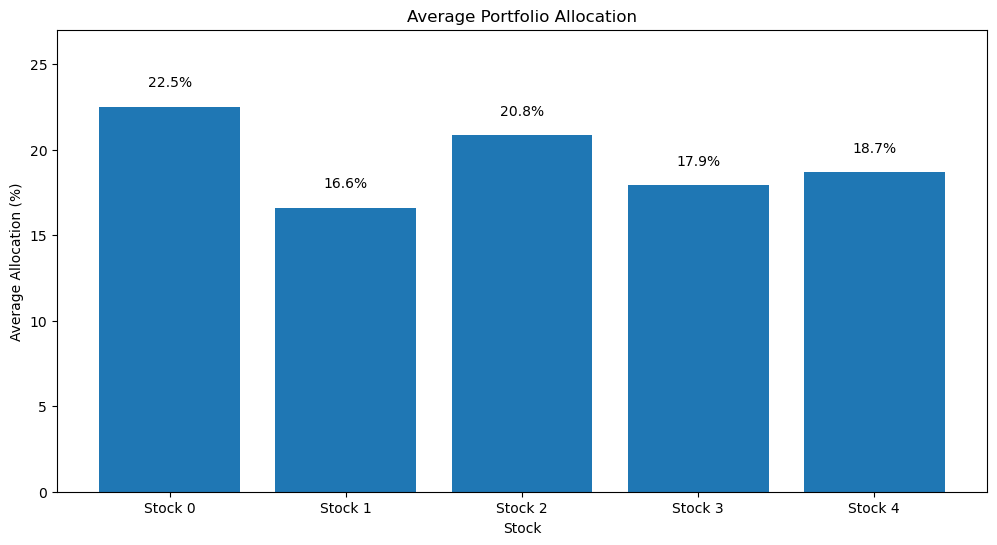

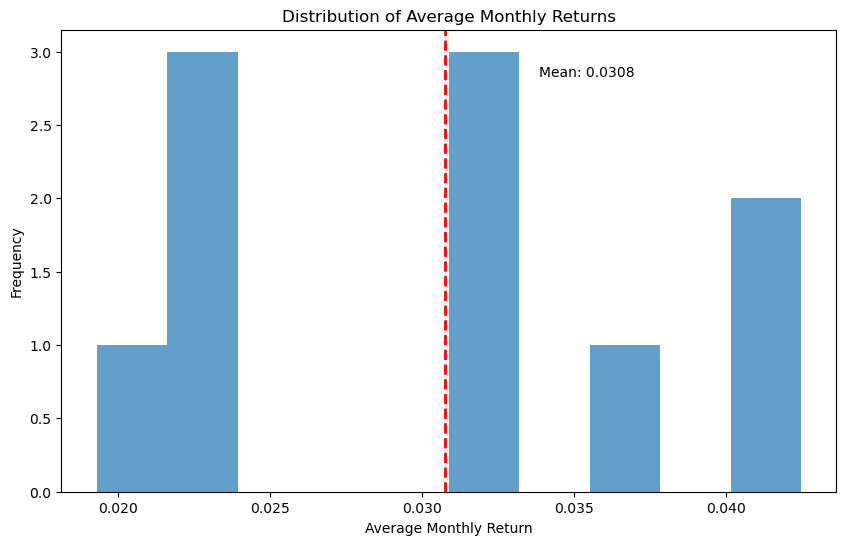

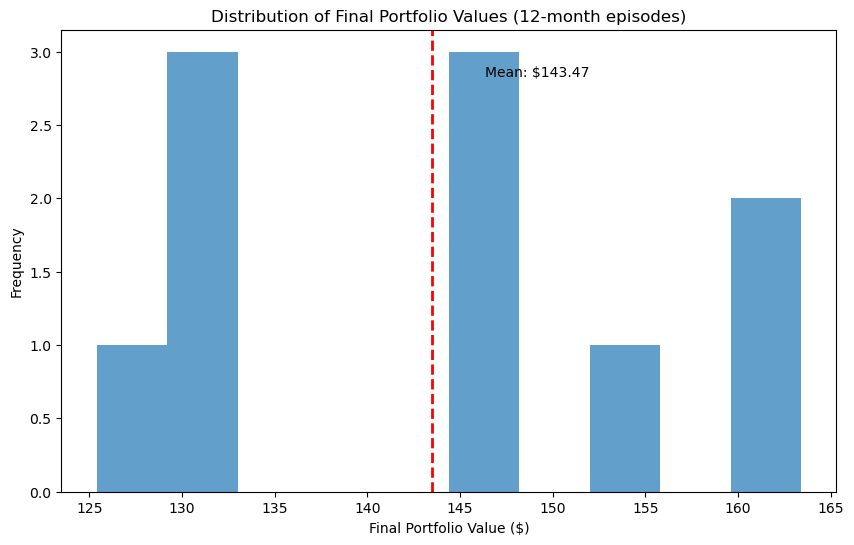

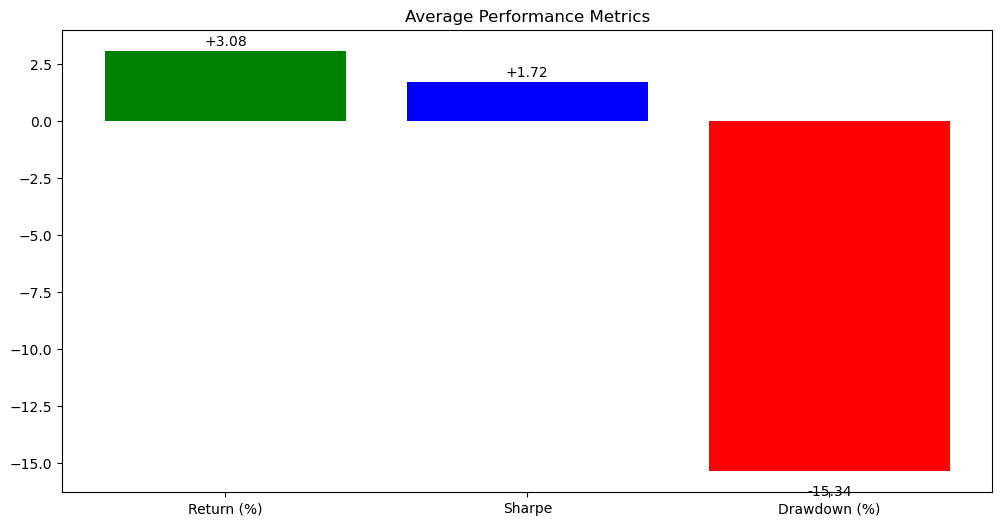

In [ ]:
# data_dir must be appended before the filename
data_dir = "/Users/newuser/Projects/robust_algo_trader/data/gen_synthetic_data/preprocessed_data"

# Load stock data from directory
stock_data_list = []
instrument_list = ["BIT", "CAQD", "CDUV", "CDZ", "CMA", "CQFV", "DEI", "DNW", "DPJE", "EZIG"] 

for instrument in instrument_list:
    file_path = f"{data_dir}/preprocessed_{instrument}.csv"
    df = pd.read_csv(file_path)
    
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
    
    stock_data_list.append(df)
    print(f"Loaded {instrument} with {len(df)} data points")

save_dir = './models'
os.makedirs(save_dir, exist_ok=True)


train_and_evaluate(
    stock_data_list=stock_data_list,
    save_dir=save_dir,
    total_timesteps=100000,
    eval_episodes=10,
)

print("Training and evaluation complete!")